## import package and data

In [1]:
# Install package first
# We use uv for faster installation

# Google Colab is setting some uv-related environment variables, that seem to have broken with the a Colab update.
# The Colab team is tracking this internally (googlecolab/colabtools#5237).
# https://github.com/googlecolab/colabtools/issues/5237#issuecomment-2786440777
import os
os.environ["UV_CONSTRAINT"] = os.environ["UV_BUILD_CONSTRAINT"] = ""  # add this line to solve the uv related issue

!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab
!uv pip uninstall transformers
# !uv pip install -q torch==2.3.0 torchvision==0.18.0 --index-url https://download.pytorch.org/whl/cu118
!uv pip install -q transformers==4.44.2


## if there seems to be inconsistency due to numpy & pandas versions, do the following
# !uv pip uninstall pandas numpy
# !uv pip install -q --force-reinstall numpy==1.26.4 --system
# !uv pip install -q --force-reinstall pandas==2.2.2 --system
## You may need to restart colab kernel

Using Python 3.11.12 environment at: /usr
Uninstalled 1 package in 244ms
 - transformers==4.44.2


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [4]:
from scipy import signal
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.signal import welch
from statsmodels.tsa.stattools import adfuller
import itertools
warnings.filterwarnings("ignore")

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive/Online Retail

/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail


In [7]:
ls

'Chronos on Previous Categories'/  'Previous Results'/
 Chronos_Retail_daily.ipynb         product_cluster_labels_a2.csv
 Chronos_Retail_weekly.ipynb        product_cluster_labels_a5.csv
 cleaned_retail_dataset.csv         product_cluster_labels_k2.csv
 Data_Cleaning_EDA.ipynb            product_cluster_labels_k5.csv
'Final Deliverable'/               'Prophet Final version.ipynb'
 online_retail_II.xlsx              Sales_Categorization.ipynb
'Previous Categorization'/         'Weekly Prophet.ipynb'
'Previous Code'/                    XGBoost_Retail_weekly.ipynb


In [8]:
file_path = "cleaned_retail_dataset.csv"
df = pd.read_csv(file_path)
print(df.describe())
df.head()

             Invoice       Quantity          Price          Sales
count  753156.000000  753156.000000  753156.000000  753156.000000
mean   538615.927816      11.462284       3.239064      20.177644
std     27172.439129      66.811910       4.787790      81.290516
min    489434.000000       1.000000       0.030000       0.060000
25%    516015.000000       1.000000       1.250000       4.160000
50%    538566.000000       4.000000       2.080000      10.200000
75%    563193.000000      12.000000       3.950000      17.700000
max    581587.000000   12960.000000    1157.150000   38970.000000


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,30.0


In [9]:
# Aggregate total sales per day across all categories
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df_all = df.copy()
df_all = df_all.set_index('InvoiceDate')

total_sales = df_all['Sales'].resample('D').sum().reset_index()
total_sales.columns = ['ds', 'y']
total_sales['ds'] = pd.to_datetime(total_sales['ds'])
total_sales['y'] = total_sales['y'].astype(float)
print(total_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      739 non-null    datetime64[ns]
 1   y       739 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.7 KB
None


In [10]:
total_sales

,ds,y
0,2009-12-01,43548.81
1,2009-12-02,55576.94
2,2009-12-03,51673.62
3,2009-12-04,28850.91
4,2009-12-05,5071.30
...,...,...
734,2011-12-05,71081.28
735,2011-12-06,48012.31
736,2011-12-07,60749.62
737,2011-12-08,71954.32


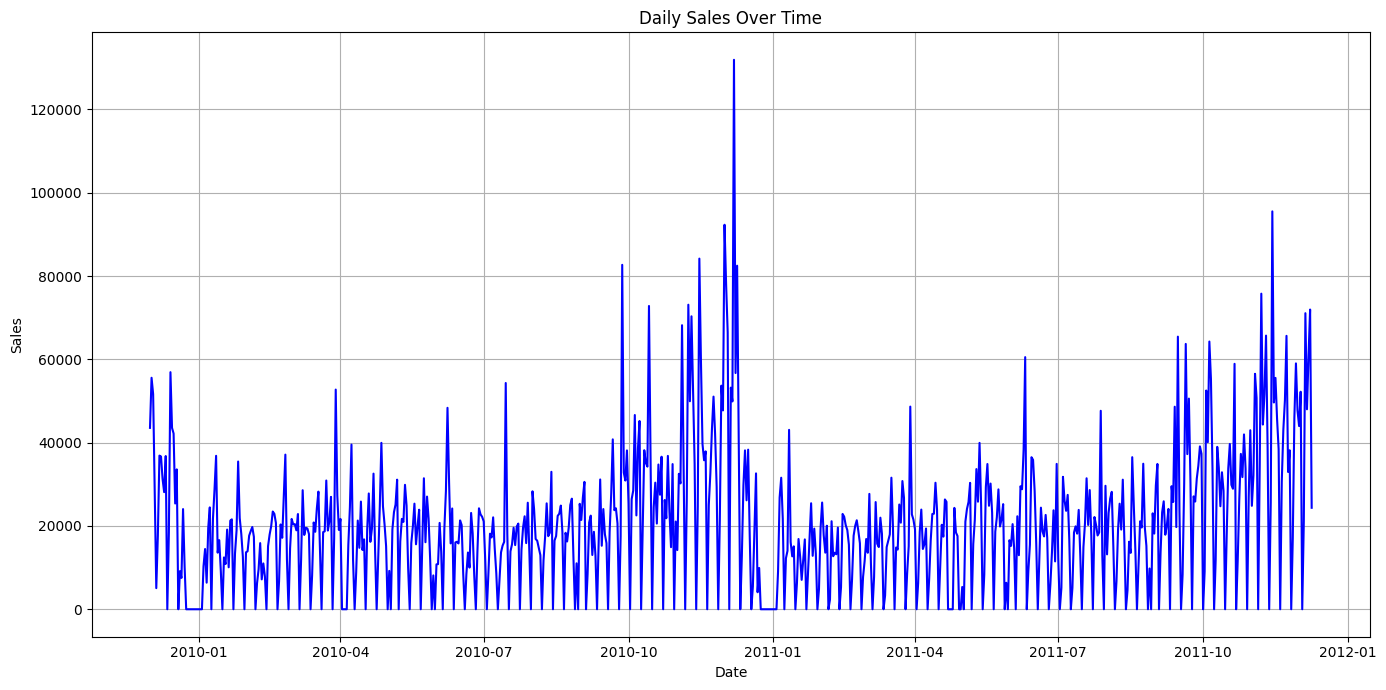

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(total_sales['ds'], total_sales['y'], color='blue', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# change data format to be used in Chronos
total_sales_chronos = total_sales.rename(columns={'ds': 'timestamp', 'y': 'target'})
total_sales_chronos['item_id'] = 1
print(total_sales_chronos.head())

   timestamp    target  item_id
0 2009-12-01  43548.81        1
1 2009-12-02  55576.94        1
2 2009-12-03  51673.62        1
3 2009-12-04  28850.91        1
4 2009-12-05   5071.30        1


In [13]:
total_sales_chronos = TimeSeriesDataFrame.from_data_frame(total_sales_chronos)
print(total_sales_chronos.head())
total_sales_chronos.describe()

                      target
item_id timestamp           
1       2009-12-01  43548.81
        2009-12-02  55576.94
        2009-12-03  51673.62
        2009-12-04  28850.91
        2009-12-05   5071.30


,target
count,739.000000
mean,20564.158742
std,16772.331829
min,0.000000
25%,9908.045000
50%,18794.370000
75%,27374.050000
max,131921.040000


## Chronos zero-shot model

### Chronos zero-shot bolt_tiny:

In [14]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_185211'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       11.02 GB / 12.67 GB (87.0%)
Disk Space Avail:   61.86 GB / 107.72 GB (57.4%)
Setting presets to: bolt_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'tar

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_tiny]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

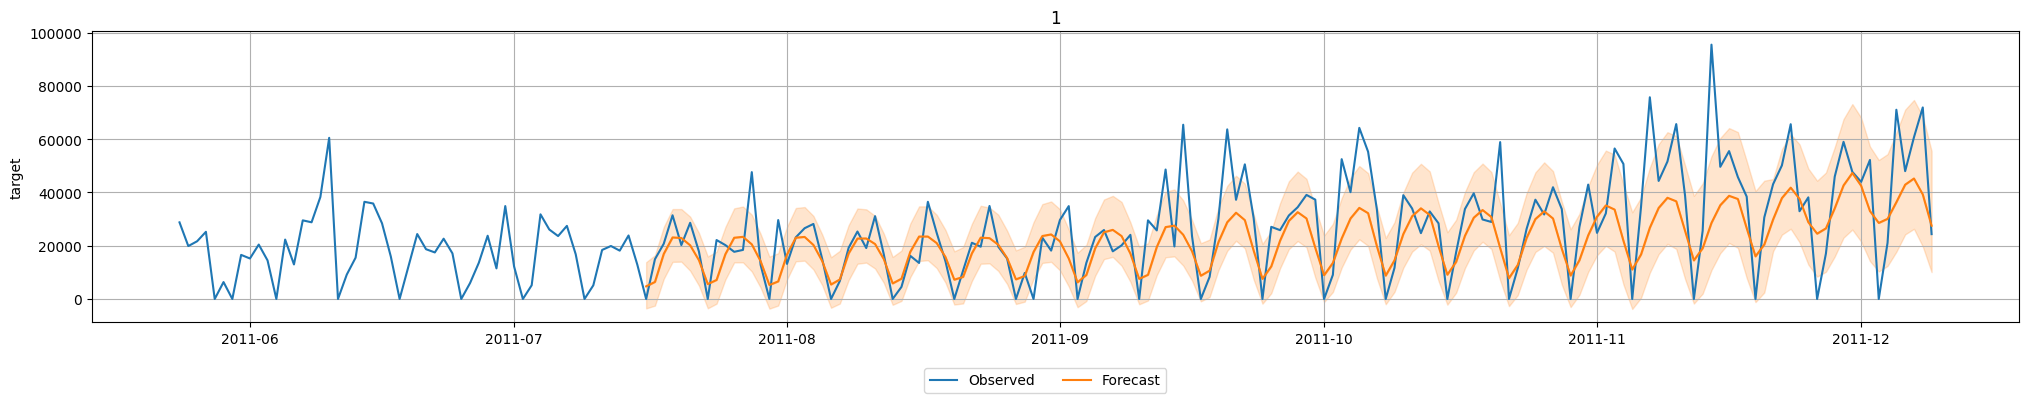

In [15]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [16]:
print(predictions.shape)
predictions.head()

(147, 10)


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1       2011-07-16   4751.222656  -3532.410156   -882.509766   1156.566406   
        2011-07-17   6408.286133  -2490.591797    373.919922   2570.416992   
        2011-07-18  16948.818359   7581.221680  10684.134766  12992.617188   
        2011-07-19  23123.244141  13943.228516  17009.376953  19248.546875   
        2011-07-20  22917.632812  14019.158203  16914.156250  19113.384766   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1       2011-07-16   3008.169922   4751.222656   6474.057617   8386.417969   
        2011-07-17   4541.902344   6408.286133   8279.534180  10371.279297   
        2011-07-18  15035.306641  16948.818359  18820.539062  20856.349609   
        2011-07-19  21225.669922  23123.244141  25091.574219  27269.984375   
        2011-07-20  21059.820312  22917.632812  24879.167969  26985.582031   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16  10603.998047  13815.820312  
        2011-07-17  12852.520508  16419.082031  
        2011-07-18  23370.574219  27020.816406  
        2011-07-19  29870.164062  33773.863281  
        2011-07-20  29661.902344  33775.964844

In [17]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_tiny],-0.295898,None,2.154683,None,16.511089,1,-0.295898,-10725.446104,-2.221063e+08,-14903.230151,-0.294251


In [20]:
test_data

target
item_id timestamp           
1       2009-12-01  43548.81
        2009-12-02  55576.94
        2009-12-03  51673.62
        2009-12-04  28850.91
        2009-12-05   5071.30
...                      ...
        2011-12-05  71081.28
        2011-12-06  48012.31
        2011-12-07  60749.62
        2011-12-08  71954.32
        2011-12-09  24364.17

[739 rows x 1 columns]

Overall MAPE for Test Period 1: 25.80%
Overall MAPE for Test Period 2: 31.73%
Overall MAPE for Test Period 3: 30.66%


<Figure size 640x480 with 0 Axes>

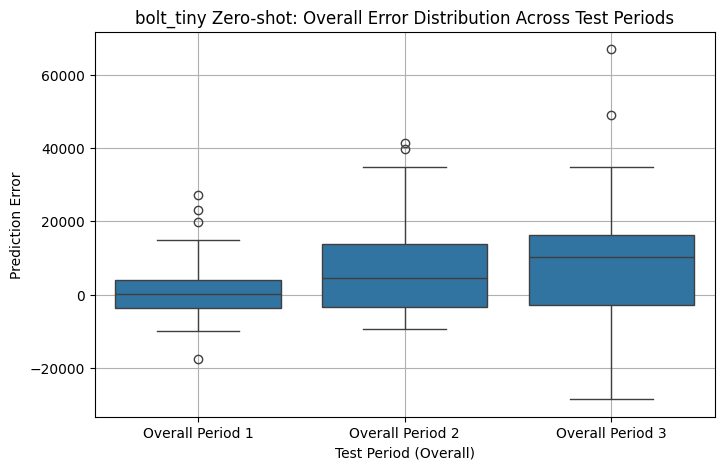

In [23]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.nan

    error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    return np.mean(error) * 100

def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

three_split_plot(predictions, 'bolt_tiny Zero-shot')

### Chronos zero-shot bolt_mini:

In [24]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_mini",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_191529'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.50 GB / 12.67 GB (82.8%)
Disk Space Avail:   61.78 GB / 107.72 GB (57.4%)
Setting presets to: bolt_mini

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'tar

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_mini]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

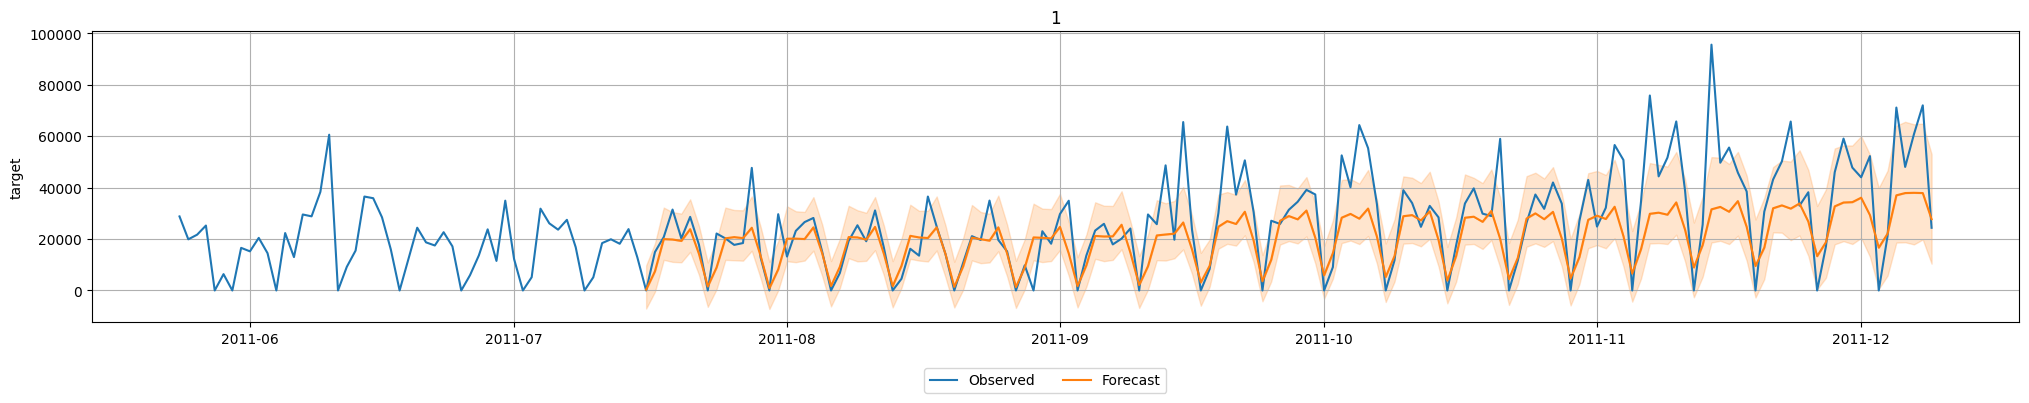

In [25]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [26]:
print(predictions.shape)
predictions.head()

(147, 10)


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1       2011-07-16    310.458984  -7031.353516  -4731.304688  -2888.521484   
        2011-07-17   7466.321289   -480.378906   1977.328125   3902.713867   
        2011-07-18  19973.550781  11907.223633  14304.658203  16258.874023   
        2011-07-19  19812.091797  11116.747070  13950.307617  16084.015625   
        2011-07-20  19261.513672  10949.488281  13611.505859  15670.628906   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1       2011-07-16  -1248.857422    310.458984   2034.636719   3940.730469   
        2011-07-17   5625.280273   7466.321289   9322.518555  11459.309570   
        2011-07-18  18113.107422  19973.550781  21969.656250  24423.492188   
        2011-07-19  17982.871094  19812.091797  21716.220703  23900.443359   
        2011-07-20  17469.214844  19261.513672  21138.617188  23293.187500   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   6205.146484   9714.500977  
        2011-07-17  14173.492188  18306.681641  
        2011-07-18  27571.474609  32216.730469  
        2011-07-19  26440.160156  30438.119141  
        2011-07-20  25830.341797  29888.980469

In [27]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_mini],-0.289957,None,2.941106,None,0.008009,1,-0.289957,-10246.738391,-2.221817e+08,-14905.760456,-0.290504


Overall MAPE for Test Period 1: 24.25%
Overall MAPE for Test Period 2: 29.90%
Overall MAPE for Test Period 3: 32.89%


<Figure size 640x480 with 0 Axes>

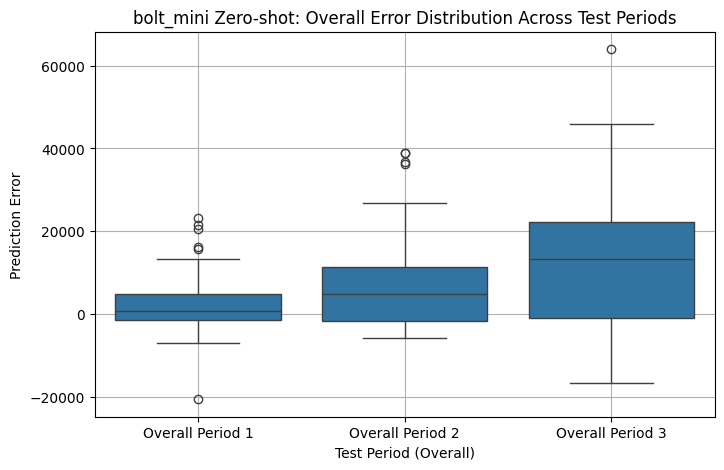

In [28]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

three_split_plot(predictions, 'bolt_mini Zero-shot')

### Chronos zero-shot bolt_small:

In [29]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_191645'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.43 GB / 12.67 GB (82.3%)
Disk Space Avail:   61.71 GB / 107.72 GB (57.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 't

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

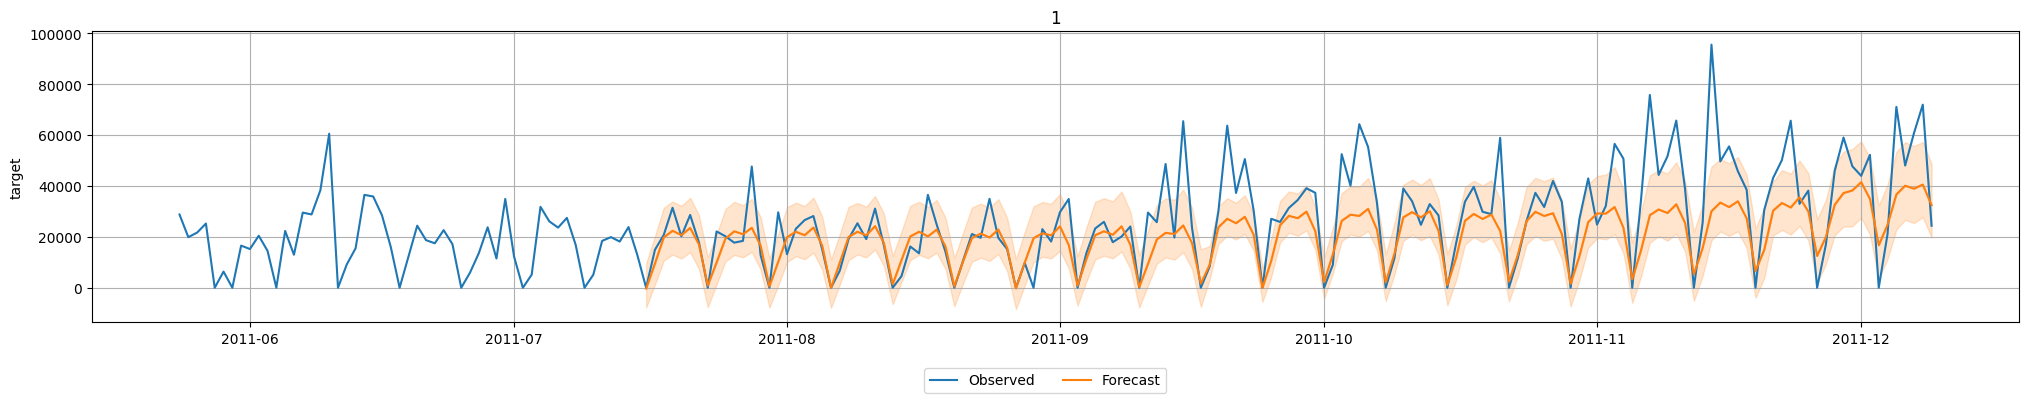

In [30]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [31]:
print(predictions.shape)
predictions.head()

(147, 10)


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1       2011-07-16   -314.533203  -7786.855469  -5424.443359  -3556.304688   
        2011-07-17   9572.921875   1275.654297   3956.525391   6051.044922   
        2011-07-18  19802.927734  10672.777344  13725.912109  15907.824219   
        2011-07-19  22401.232422  13017.076172  16175.183594  18483.666016   
        2011-07-20  20688.673828  11503.386719  14595.392578  16811.613281   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1       2011-07-16  -1970.650391   -314.533203   1359.261719   3246.036133   
        2011-07-17   7847.869141   9572.921875  11428.595703  13492.320312   
        2011-07-18  17931.628906  19802.927734  21810.466797  24124.326172   
        2011-07-19  20472.539062  22401.232422  24380.279297  26689.441406   
        2011-07-20  18801.808594  20688.673828  22648.023438  24911.062500   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   5661.493164   9559.958984  
        2011-07-17  16083.617188  20306.912109  
        2011-07-18  26918.714844  31414.500000  
        2011-07-19  29524.392578  33894.171875  
        2011-07-20  27684.109375  32164.820312

In [32]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_small],-0.288697,None,2.632657,None,0.006311,1,-0.288697,-9838.424399,-2.166673e+08,-14719.621344,-0.288359


Overall MAPE for Test Period 1: 24.65%
Overall MAPE for Test Period 2: 28.99%
Overall MAPE for Test Period 3: 32.77%


<Figure size 640x480 with 0 Axes>

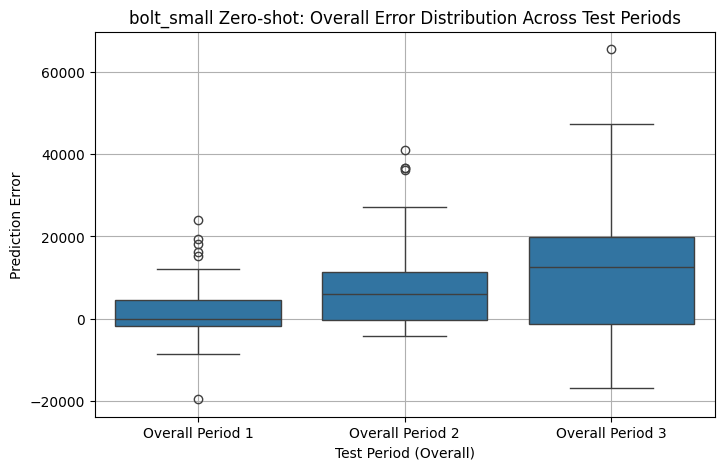

In [33]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

three_split_plot(predictions, 'bolt_small Zero-shot')

### Chronos zero-shot bolt_base:

In [34]:
prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_191729'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.44 GB / 12.67 GB (82.4%)
Disk Space Avail:   61.54 GB / 107.72 GB (57.1%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 147,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'tar

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

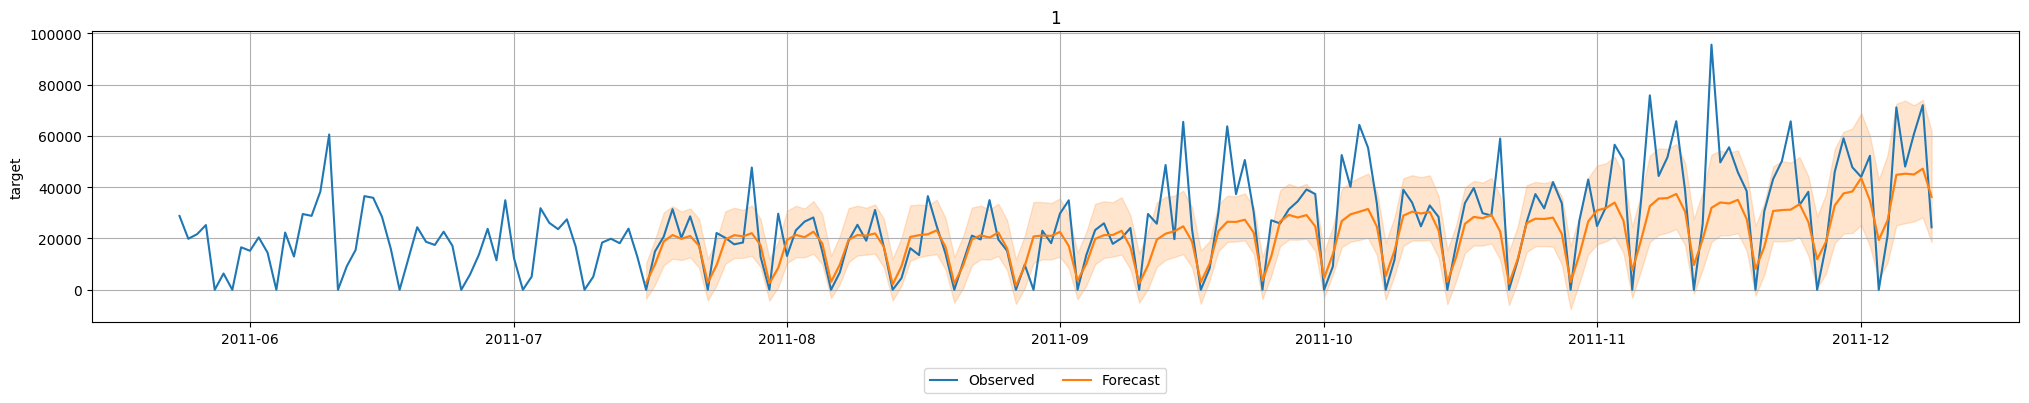

In [35]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

In [36]:
print(predictions.shape)
predictions.head()

(147, 10)


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1       2011-07-16   2705.583008  -3443.806641  -1239.925781    273.917969   
        2011-07-17   9966.151367   1910.095703   4783.661133   6732.791992   
        2011-07-18  18878.332031   9566.096680  12610.142578  14919.750000   
        2011-07-19  21370.750000  12132.632812  15188.575195  17448.964844   
        2011-07-20  19879.322266  11594.318359  14329.102539  16365.175781   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1       2011-07-16   1556.593750   2705.583008   3930.724609   5363.379883   
        2011-07-17   8411.370117   9966.151367  11510.843750  13333.750977   
        2011-07-18  16940.664062  18878.332031  20793.576172  22962.683594   
        2011-07-19  19407.513672  21370.750000  23377.550781  25542.246094   
        2011-07-20  18096.048828  19879.322266  21765.201172  23815.728516   

                             0.8           0.9  
item_id timestamp                               
1       2011-07-16   7271.401367  10469.629883  
        2011-07-17  15655.492188  19457.615234  
        2011-07-18  25640.488281  30122.480469  
        2011-07-19  28211.128906  32581.179688  
        2011-07-20  26304.695312  30478.626953

In [37]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_base],-0.273712,None,7.376844,None,0.00994,1,-0.273712,-9700.19475,-1.973111e+08,-14046.747516,-0.279666


Overall MAPE for Test Period 1: 25.02%
Overall MAPE for Test Period 2: 29.17%
Overall MAPE for Test Period 3: 29.64%


<Figure size 640x480 with 0 Axes>

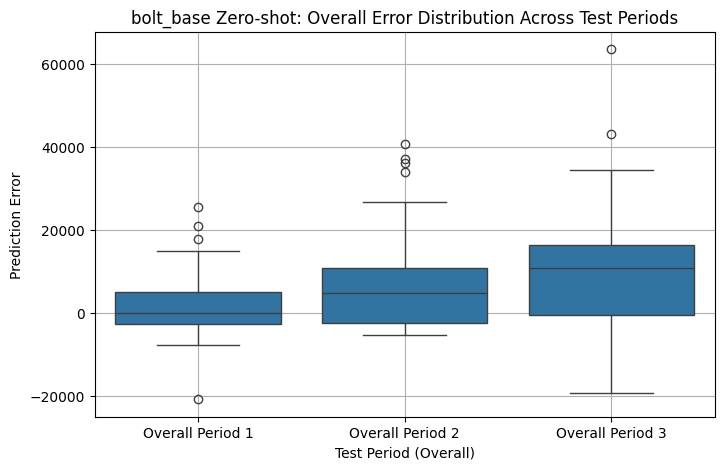

In [38]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

three_split_plot(predictions, 'bolt_base Zero-shot')

## Chronos fine-tuned model

### Chronos fine tune bolt_tiny

#### manually set hyperparameters tuning

In [44]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_tiny", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_tiny", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_193548'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       9.97 GB / 12.67 GB (78.7%)
Disk Space Avail:   60.42 GB / 107.72 GB (56.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_

In [48]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,WeightedEnsemble,-0.245861,-0.270943,2.706314,1.695103,0.534707,5,-0.245861,-8555.840569,-1.489079e+08,-12202.783364,-0.274432
1,ChronosFineTuned[bolt_tiny]/T1,-0.278811,-0.298456,0.893007,0.118386,59.696837,2,-0.278811,-10057.437966,-1.960777e+08,-14002.774256,-0.283081
2,ChronosFineTuned[bolt_tiny]/T3,-0.283344,-0.302025,0.730195,0.075351,371.447567,4,-0.283344,-10230.171615,-2.049092e+08,-14314.651038,-0.348009
3,ChronosZeroShot[bolt_tiny],-0.295898,-0.304209,1.076461,1.501366,0.018275,1,-0.295898,-10725.446104,-2.221063e+08,-14903.230151,-0.294251
4,ChronosFineTuned[bolt_tiny]/T2,-0.333032,-0.306374,0.727244,0.076957,58.648458,3,-0.333032,-11737.110880,-2.753226e+08,-16592.847451,-0.357786


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


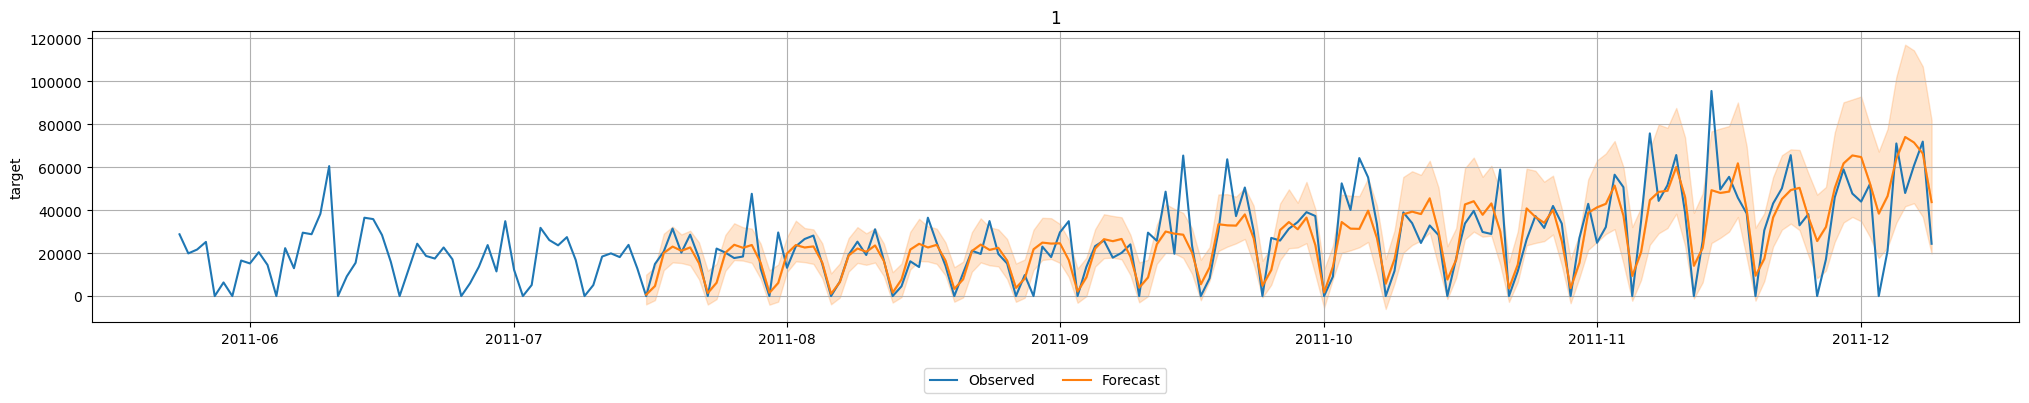

In [49]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 25.39%
Overall MAPE for Test Period 2: 28.94%
Overall MAPE for Test Period 3: 27.95%


<Figure size 640x480 with 0 Axes>

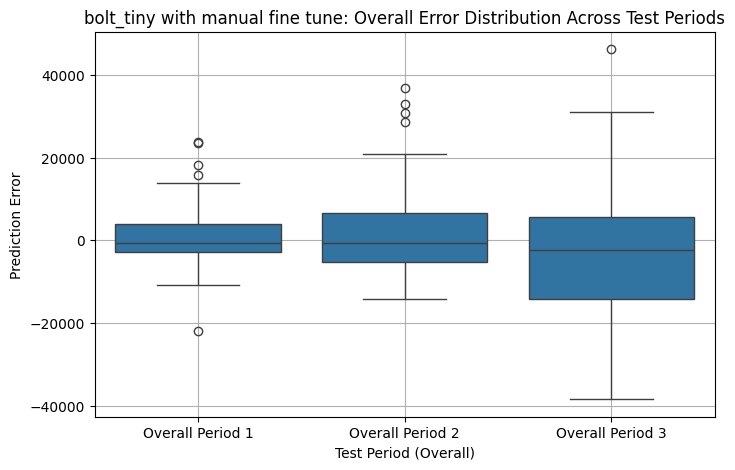

In [50]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']

three_split_plot(predictions, 'bolt_tiny with manual fine tune')

### Chronos fine tune bolt_mini (currently best one)

#### manually set hyperparameters tuning (currently best one)

In [40]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_mini", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_mini", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_192331'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.53 GB / 12.67 GB (83.1%)
Disk Space Avail:   60.65 GB / 107.72 GB (56.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch

In [41]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,WeightedEnsemble,-0.231906,-0.261444,4.058017,2.354502,0.649419,5,-0.231906,-7952.757702,-1.401586e+08,-11838.860139,-0.249931
1,ChronosFineTuned[bolt_mini]/T2,-0.256004,-0.279194,1.074072,0.119819,127.031939,3,-0.256004,-8913.727327,-1.651963e+08,-12852.872425,-0.298182
2,ChronosFineTuned[bolt_mini]/T1,-0.263056,-0.267566,0.826413,0.126457,146.960945,2,-0.263056,-9320.660160,-1.840769e+08,-13567.494924,-0.271409
3,ChronosFineTuned[bolt_mini]/T3,-0.273699,-0.292902,1.079813,0.163069,263.248808,4,-0.273699,-9803.082040,-1.999718e+08,-14141.137597,-0.328746
4,ChronosZeroShot[bolt_mini],-0.289957,-0.271179,1.071335,1.945157,0.017141,1,-0.289957,-10246.738391,-2.221817e+08,-14905.760456,-0.290504


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


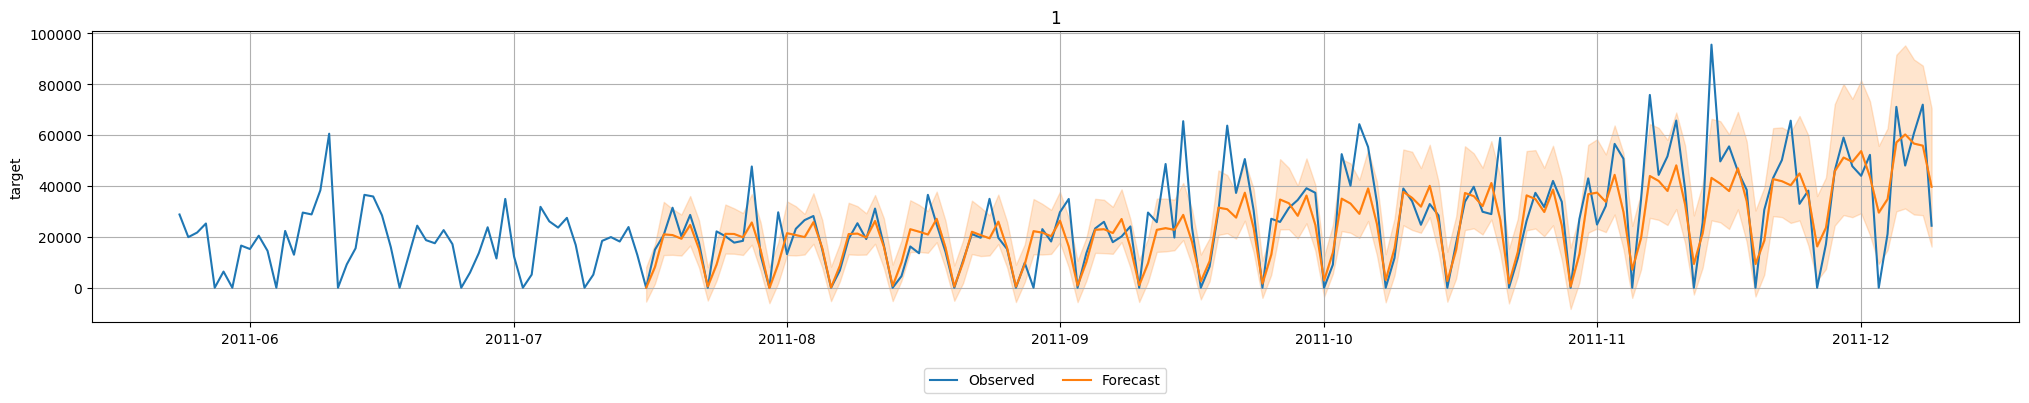

In [42]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 24.19%
Overall MAPE for Test Period 2: 26.49%
Overall MAPE for Test Period 3: 24.27%


<Figure size 640x480 with 0 Axes>

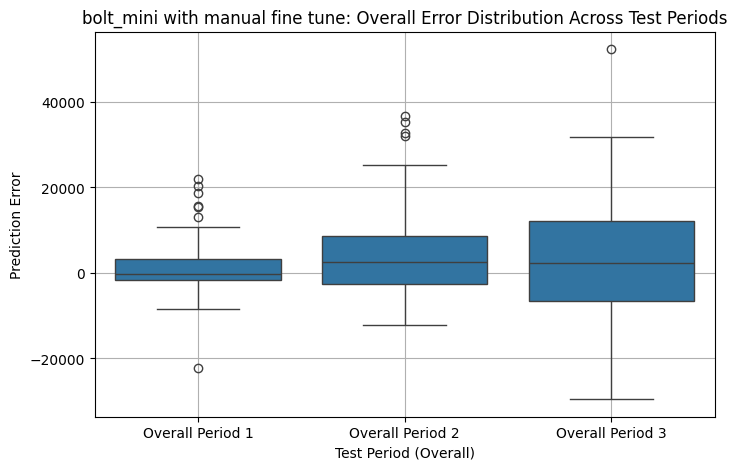

In [43]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions


# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.nan

    error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    return np.mean(error) * 100

def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

three_split_plot(predictions, 'bolt_mini with manual fine tune')

### Chronos fine tune bolt_small

#### manually set hyperparameters tuning

In [51]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, eval_metric="MAPE").fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_small", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_194654'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       9.91 GB / 12.67 GB (78.2%)
Disk Space Avail:   60.33 GB / 107.72 GB (56.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batc

In [55]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_small]/T1,-0.269026,-0.308301,1.763264,0.215014,266.066039,2,-0.254609,-8737.350133,-1.737642e+08,-13181.965040,-0.269026
1,WeightedEnsemble,-0.288359,-0.291647,1.462068,2.655669,0.389791,4,-0.288697,-9838.424399,-2.166673e+08,-14719.621344,-0.288359
2,ChronosZeroShot[bolt_small],-0.288359,-0.291647,1.457660,2.655669,0.014744,1,-0.288697,-9838.424399,-2.166673e+08,-14719.621344,-0.288359
3,ChronosFineTuned[bolt_small]/T2,-0.339233,-0.412172,1.338335,0.231538,269.557311,3,-0.271786,-9478.001357,-1.966390e+08,-14022.803283,-0.339233


Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[bolt_small]


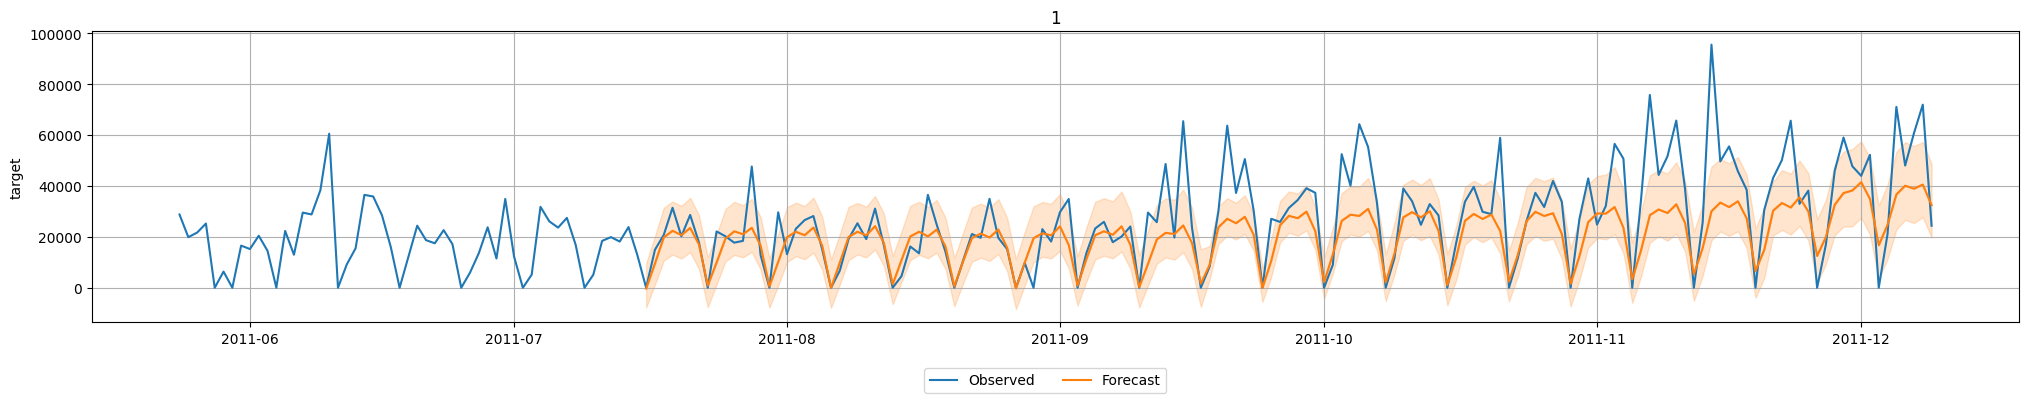

In [56]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 24.65%
Overall MAPE for Test Period 2: 28.99%
Overall MAPE for Test Period 3: 32.77%


<Figure size 640x480 with 0 Axes>

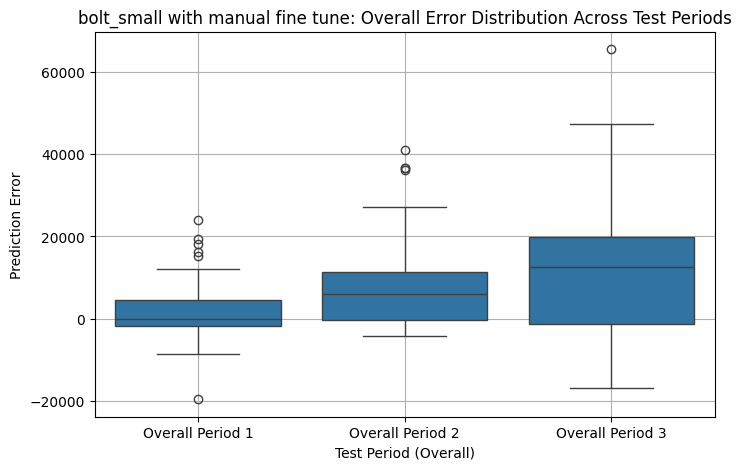

In [57]:
three_split_plot(predictions, 'bolt_small with manual fine tune')

### Chronos fine tune bolt_base

#### manually set hyperparameters tuning

In [58]:
from autogluon.common import space

prediction_length = int(len(total_sales_chronos)*0.2)
train_data, test_data = total_sales_chronos.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters = {
            "Chronos": [
                {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
                {"model_path": "bolt_base", "fine_tune": True,
                 "fine_tune_lr": space.Real(0.000001, 0.001, log=True),
                 "fine_tune_steps": space.Categorical(125, 250, 500, 1000),
                 "fine_tune_batch_size": space.Categorical(16, 32, 64),
                 "ag_args": {"name_suffix": "FineTuned"}}
            ]
        },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=1200,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1bsuuXsN9f_3_uPMxfoq1e9R2u7sIHJwZ/Online Retail/AutogluonModels/ag-20250425_195705'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       9.98 GB / 12.67 GB (78.7%)
Disk Space Avail:   59.82 GB / 107.72 GB (55.5%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_

In [62]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,WeightedEnsemble,-0.245828,-0.276155,2.738767,0.783713,0.269778,3,-0.245828,-8716.744204,-1.617567e+08,-12718.359685,-0.265394
1,ChronosFineTuned[bolt_base]/T1,-0.245828,-0.276155,2.734291,0.783713,494.784039,2,-0.245828,-8716.744204,-1.617567e+08,-12718.359685,-0.265394
2,ChronosZeroShot[bolt_base],-0.273712,-0.286882,2.248058,7.820732,0.018561,1,-0.273712,-9700.194750,-1.973111e+08,-14046.747516,-0.279666


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_base]/T1


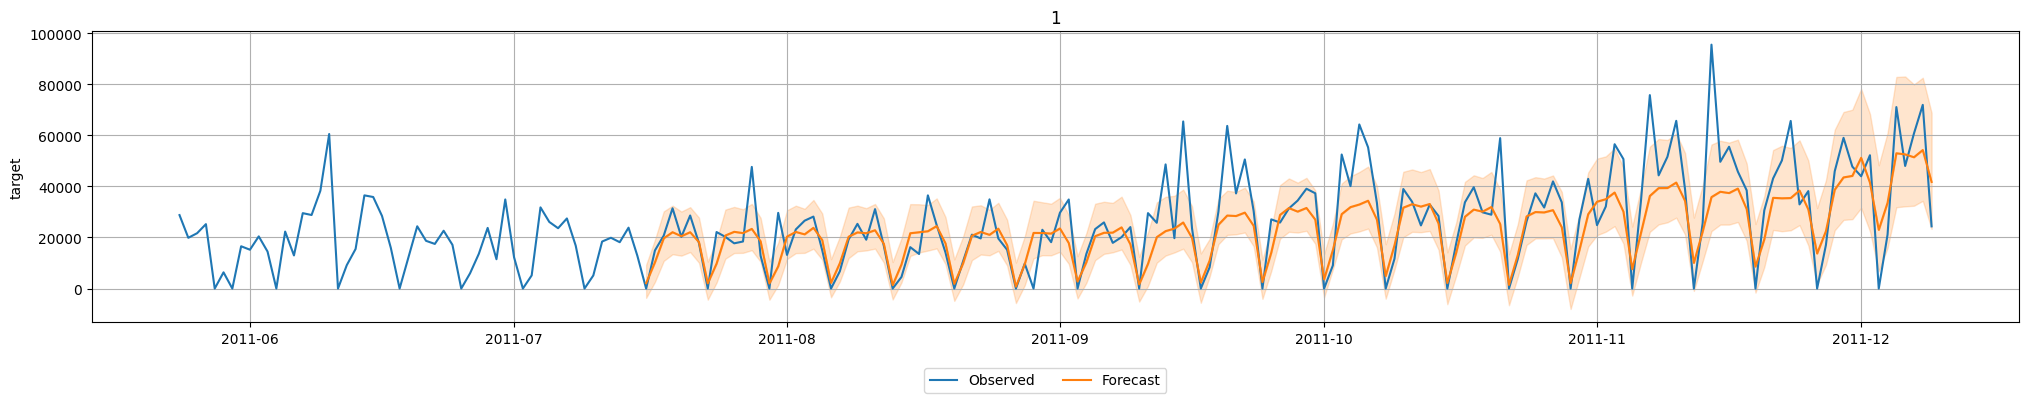

In [63]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=total_sales_chronos,
    predictions=predictions,
    item_ids=total_sales_chronos.item_ids[:],
    max_history_length=200,
);

Overall MAPE for Test Period 1: 25.67%
Overall MAPE for Test Period 2: 27.12%
Overall MAPE for Test Period 3: 26.81%


<Figure size 640x480 with 0 Axes>

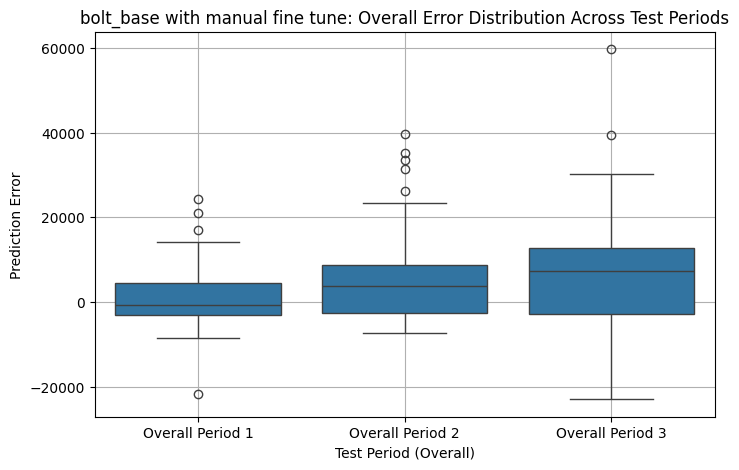

In [64]:
three_split_plot(predictions, 'bolt_base with manual fine tune')